In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns


from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D ,MaxPooling1D , Conv1D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from warnings import simplefilter
from sklearn.metrics import f1_score

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Load Crema DataSet

In [2]:
CREMA  = '/kaggle/input/speech-emotion-recognition-en/Crema/' 
audios = os.listdir(CREMA)
audios.sort()
print(audios[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [3]:
y = []
file_path = []

for file in audios:
    # storing file paths
    file_path.append(CREMA + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        y.append(1)
    elif part[2] == 'ANG':
        y.append(2)
    elif part[2] == 'DIS':
        y.append(3)
    elif part[2] == 'FEA':
        y.append(4)
    elif part[2] == 'HAP':
        y.append(5)
    elif part[2] == 'NEU':
        y.append(6)
    else:
        y.append(7)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(y, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,2,/kaggle/input/speech-emotion-recognition-en/Cr...
1,3,/kaggle/input/speech-emotion-recognition-en/Cr...
2,4,/kaggle/input/speech-emotion-recognition-en/Cr...
3,5,/kaggle/input/speech-emotion-recognition-en/Cr...
4,6,/kaggle/input/speech-emotion-recognition-en/Cr...


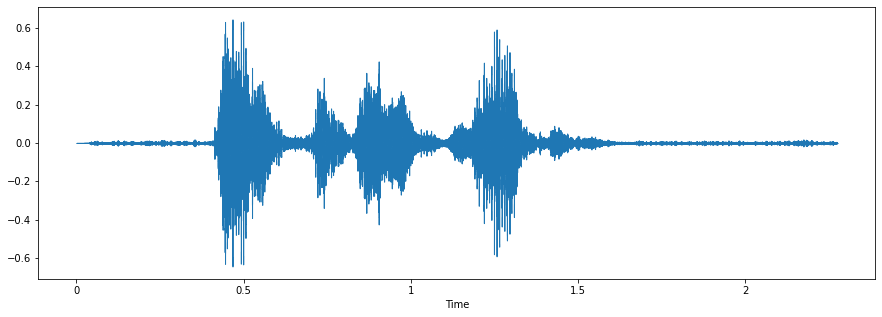

In [4]:
fname =  file_path[0]
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

# Create the Feature Space 

In [5]:
 def pad_trunc(file_path):
    FRAME_SIZE = 1024
    HOP_LENGTH = 512
    MAX_LEN = 56071
    signals = []
    for audio in file_path:
        sig , sr = librosa.load(audio)
        if len(sig) > MAX_LEN :
            sig = sig[:MAX_LEN]
        else :
            pad = (MAX_LEN - len(sig))//2
            sig = np.pad(sig, ( pad   , MAX_LEN - len(sig) - pad), 'constant')
        signals.append(sig)
    return signals
        

In [6]:
signals = pad_trunc(file_path)

# ZCR+ RMS

In [7]:
FRAME_SIZE = 1024
HOP_LENGTH = 512
def get_dataMatrix_1d(signals):
    data_1d = []
    for sig in signals:
        rms = librosa.feature.rms(sig, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        zcr = librosa.feature.zero_crossing_rate(sig, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        arr = np.hstack((rms,zcr))
        arr = arr.reshape((arr.shape[0], 1))
        data_1d.append(arr)
    return data_1d


In [8]:
data_1d = get_dataMatrix_1d(signals)

In [9]:
def get_dataMatrix_2d(signals):
    data_2d = []
    for sig in signals:
        mel_spectrogram = librosa.feature.melspectrogram(sig, sr=22050, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, n_mels=80)
        mel_spectrogram = mel_spectrogram.reshape((mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1))
        data_2d.append(mel_spectrogram)
    return data_2d

In [10]:
data_2d = get_dataMatrix_2d(signals)

# Building the Model

# *  Split Data

In [11]:
def split(X,y,s):
    x_train, x_test , y_train , y_test = train_test_split(X,y,test_size=s)
    return np.array(x_train) ,np.array(y_train), np.array(x_test), np.array(y_test)

In [12]:
def prepare_data(X,y,test_size , validation_size):
    
    #test data
    X_train, y_train, X_test , y_test = split(X ,y ,test_size)
    
    #validation data
    X_train,  y_train ,X_validation , y_validation = split(X_train,y_train ,validation_size)
    
    return X_train , X_test , X_validation , y_train , y_test , y_validation

In [13]:
X_train , X_test , X_validation , y_train , y_test , y_validation = prepare_data(data_1d,y,0.3,0.05)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)


(4948, 220, 1)
(2233, 220, 1)
(261, 220, 1)
(4948,)
(2233,)
(261,)


# 1D CNN Model

In [28]:
def build_model_1(input_shape):
    CNNmodel = keras.Sequential()
    CNNmodel.add(layers.Conv1D(64, 11, activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv1D(64, 11, activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.MaxPooling1D(2))
    CNNmodel.add(layers.Conv1D(128, 7, activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv1D(128, 7, activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.MaxPooling1D(2))
    CNNmodel.add(layers.Conv1D(256, 3, activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv1D(256, 3, activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.MaxPooling1D(2))
    
    CNNmodel.add(layers.Flatten())
    CNNmodel.add(layers.Dense(64, activation='relu'))
    CNNmodel.add(layers.Dropout(0.2))
    CNNmodel.add(layers.Dense(32, activation='relu'))
    CNNmodel.add(layers.Dense(24, activation='softmax'))
    return CNNmodel

# 2D CNN Model 

In [15]:
def build_model(input_shape):

    CNNmodel = keras.Sequential()
    CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same", input_shape=input_shape))

    CNNmodel.add(layers.MaxPooling2D((2, 2)))
    CNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu',padding="same", input_shape=input_shape))
    
    CNNmodel.add(layers.MaxPooling2D((2, 2)))
    CNNmodel.add(layers.Conv2D(256, (3, 3), activation='relu',padding="same", input_shape=input_shape))
    CNNmodel.add(layers.Conv2D(256, (3, 3), activation='relu',padding="same", input_shape=input_shape))

    CNNmodel.add(layers.MaxPooling2D((2, 2)))
 
    
    CNNmodel.add(layers.Flatten())
    CNNmodel.add(layers.Dense(64, activation='relu'))
    CNNmodel.add(layers.Dropout(0.2))
    CNNmodel.add(layers.Dense(32, activation='relu'))
    CNNmodel.add(layers.Dense(24, activation='softmax'))
    

    return CNNmodel


# # Big Picture

#  For 1CNN Model

In [29]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test =  prepare_data(data_1d,y,0.3,0.05)

# create network
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model_1(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 220, 64)           768       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 220, 64)           45120     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 110, 64)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 110, 128)          57472     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 110, 128)          114816    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 55, 128)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 55, 256)          

In [30]:
# accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', test_acc)

# f1_score

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
yhat_classes=np.argmax(yhat_probs,axis=1)

f1 = f1_score(y_test, yhat_classes,average='weighted')
print('F1 score: %f' % f1)


Test accuracy: 0.501915693283081
F1 score: 0.497467


[[24  2  2  7  2  5]
 [ 0 40  4  1  6  0]
 [ 5  5 19 11  6  6]
 [ 8  5  5  8 10  1]
 [ 1  6  2  1 18  3]
 [ 4  3  2  5 12 22]]


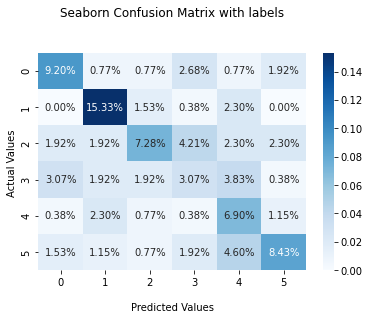

In [31]:
# confusion_matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)
ax = sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Display the visualization of the Confusion Matrix.
plt.show()


# For 2CNN Model

In [19]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test =  prepare_data(data_2d,y,0.3,0.05)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 110, 64)       640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 110, 64)       36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 110, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 55, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 55, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 55, 128)      

In [20]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', test_acc)
# f1_score

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
yhat_classes=np.argmax(yhat_probs,axis=1)

f1 = f1_score(y_test, yhat_classes,average='weighted')
print('F1 score: %f' % f1)


Test accuracy: 0.5440613031387329
F1 score: 0.536703


[[28  0  7  1  2  7]
 [ 1 21  1  1  3  2]
 [ 7  3 19  2  1 12]
 [11  3  5 19 10  5]
 [ 3  5  5  2 21  7]
 [ 4  3  5  0  1 34]]


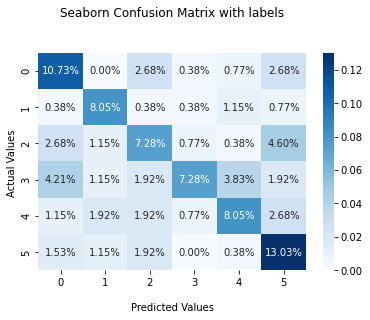

In [21]:
# confusion_matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)
ax = sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Display the visualization of the Confusion Matrix.
plt.show()